In [61]:
import numpy as np
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm
import pandas as pd
import glob
import h5py
import re
from scipy.signal import convolve
from tqdm import tqdm
import scipy.io as sio
import os
import pickle
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import tqdm
import itertools
from collections import defaultdict


plt.rc('font', size=20, family='sans-serif') 
plt.rc('axes', linewidth=1.5)
plt.rc('xtick.major', width=1.5, size=6)
plt.rc('ytick.major', width=1.5, size=6)
plt.rc('mathtext', default='regular')
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['font.family'] = 'sans-serif'


In [3]:
'''load regression info'''

root_dir = '/dartfs-hpc/scratch/f005d7d/what_where_analysis/'
figure_data_dir = '/dartfs-hpc/rc/home/d/f005d7d/attn-rnn/what_where_analysis/what-where-task-analysis/figures'
processed_path = os.path.join(root_dir, 'processed/')

with open(os.path.join(processed_path, 'all_sess_regression_info_small_stride.pkl'), 'rb') as f:
    all_sess_regression_info = pickle.load(f)

In [4]:
def plot_mean_se(ax, xxx, yyy, color, label, axis, linestyle='-'):
    mean = np.nanmean(yyy, axis)
    se = np.nanstd(yyy, axis)/np.sqrt(yyy.shape[axis])
    ax.plot(xxx, mean, c=color, label=label, lw=3, ls=linestyle)
    ax.fill_between(xxx, mean-se, mean+se, color=color, alpha=0.2)
    

In [5]:
all_sess_exp_var = np.concatenate(all_sess_regression_info['pvals'], axis=1)<0.05
all_sess_contr_pvals = np.concatenate(all_sess_regression_info['contr_pvals'], axis=1)<0.05
all_sess_betas = np.concatenate(all_sess_regression_info['betas'], axis=1)

binsize = 0.01
# gauss_SD = 0.02/binsize
win_size = int(0.05/binsize)
stride = int(0.01/binsize)

num_timesteps = 296
xxx = np.linspace(-1500, 1500-stride*binsize*1000, num=num_timesteps)

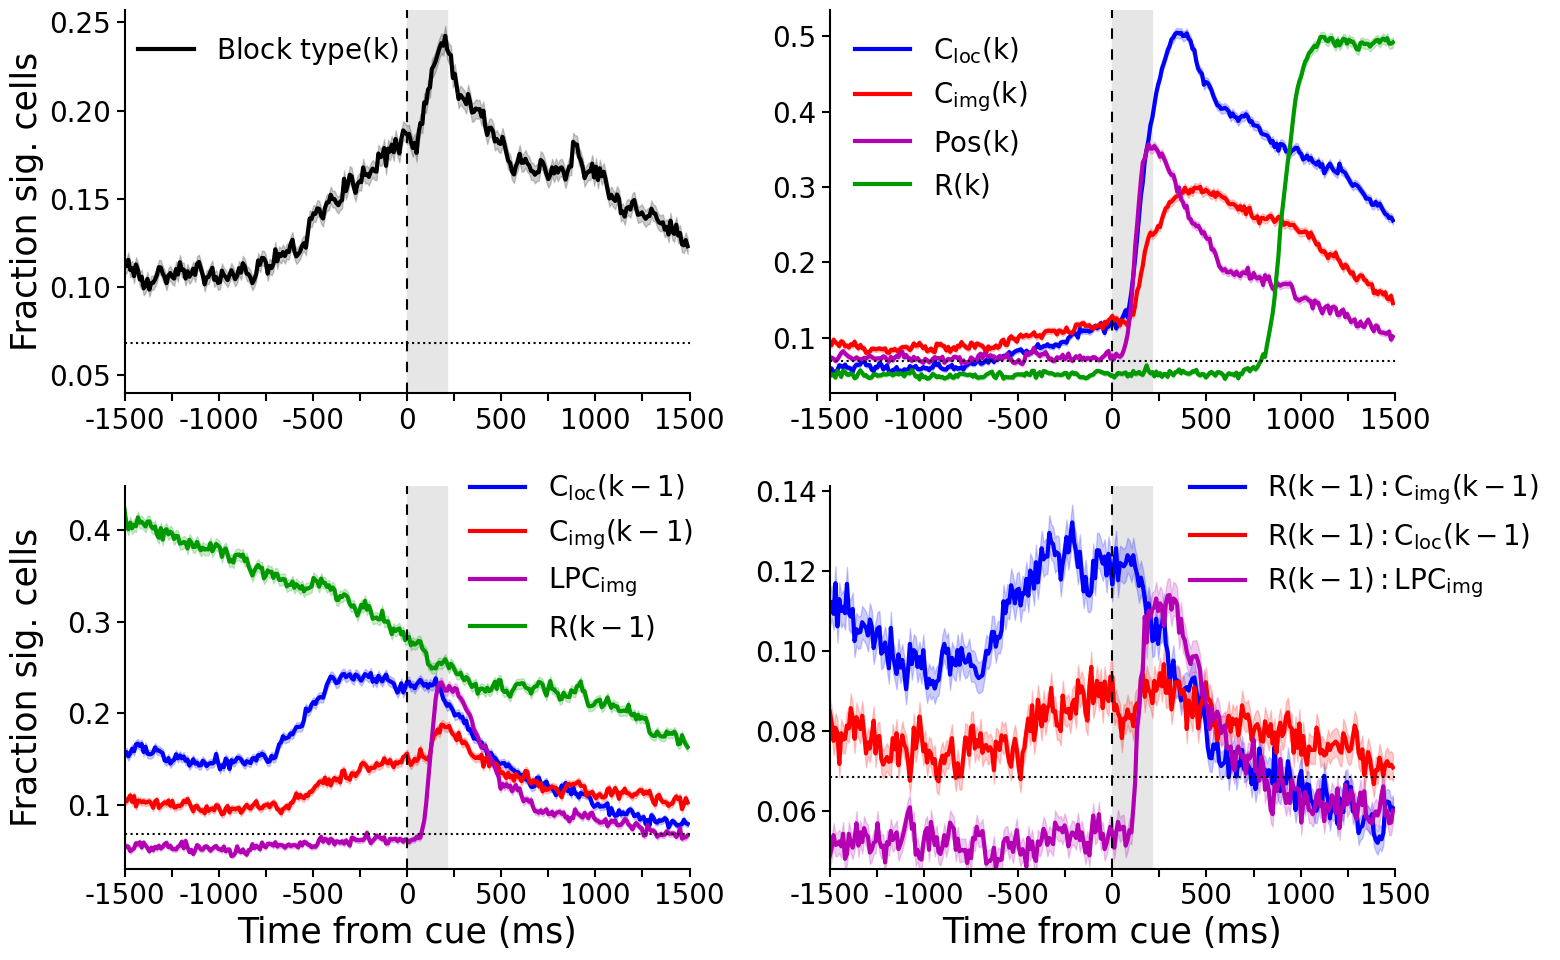

In [68]:
fig, axes = plt.subplots(2,2, figsize=(16, 10))

plot_mean_se(axes[0,0], xxx, all_sess_exp_var[...,1], color='black', label=r'$Block\ type({k})$', axis=1)
axes[0,0].legend(loc='upper left', bbox_to_anchor=[-0.02, 1.], frameon=False, labelspacing=0.5)


plot_mean_se(axes[0,1], xxx, all_sess_exp_var[...,9], color=[0,0,1], label=r'$C_{loc}({k})$', axis=1)
plot_mean_se(axes[0,1], xxx, all_sess_exp_var[...,8], color=[1,0,0], label=r'$C_{img}({k})$', axis=1)
plot_mean_se(axes[0,1], xxx, all_sess_exp_var[...,5], color=[0.7, 0, 0.7], label=r'$Pos({k})$', axis=1)
plot_mean_se(axes[0,1], xxx, all_sess_exp_var[...,11], color=[0,0.6,0], label=r'$R({k})$', axis=1)
axes[0,1].legend(loc='upper left', bbox_to_anchor=[-0.0, 1.], frameon=False, labelspacing=0.5)


plot_mean_se(axes[1,0], xxx, all_sess_exp_var[...,16], color='blue', label=r'$C_{loc}({k}-1)$', axis=1)
plot_mean_se(axes[1,0], xxx, all_sess_exp_var[...,15], color='red', label=r'$C_{img}({k}-1)$', axis=1)
plot_mean_se(axes[1,0], xxx, all_sess_exp_var[...,25], color=[0.7, 0, 0.7], label=r'$LPC_{img}$', axis=1)
plot_mean_se(axes[1,0], xxx, all_sess_exp_var[...,18], color=[0,0.6,0], label=r'$R({k}-1)$', axis=1)
axes[1,0].legend(loc='upper right', bbox_to_anchor=[1.05, 1.1], frameon=False, labelspacing=0.5)

plot_mean_se(axes[1,1], xxx, all_sess_exp_var[...,20], color='blue', 
             label=r'$R({k}-1): C_{img}({k}-1)$', axis=1)
plot_mean_se(axes[1,1], xxx, all_sess_exp_var[...,24], color='red', 
             label=r'$R({k}-1): C_{loc}({k}-1)$', axis=1)
plot_mean_se(axes[1,1], xxx, all_sess_exp_var[...,30], color=[0.7, 0, 0.7], 
             label=r'$R({k}-1): LPC_{img}$', axis=1)
axes[1,1].legend(loc='upper right', bbox_to_anchor=[1.30, 1.1], frameon=False, labelspacing=0.5)

thresh = stats.binom.ppf(1-0.001/all_sess_exp_var.shape[0]/all_sess_exp_var.shape[1], 
                         all_sess_exp_var.shape[1], 0.05)\
                    /all_sess_exp_var.shape[1]

for a in axes.flatten():
    a.axhline(thresh, ls=':', c='k')
    a.axvline(0, ls=(0, (5, 5)), c='k')
    a.set_xticks(np.arange(-1500, 1501, 250), labels=[-1500+i//2*500  if i%2==0 else "" for i in range(13)])
    ylims = [0.05-(a.get_ylim()[1]-0.05)*0.05, a.get_ylim()[1]]
    a.set_ylim(ylims)
#         a.axhline(thresh, ls=':', c='k')
    a.fill_between([0, 213], [0.0, 0.0], [1, 1], color=[0.9, 0.9, 0.9], zorder=-1)
    a.set_xlim([-1500, 1500])

axes[1,0].set_xlabel('Time from cue (ms)', fontsize=25)
axes[1,1].set_xlabel('Time from cue (ms)', fontsize=25)

axes[0,0].set_ylabel('Fraction sig. cells', fontsize=25)    
axes[1,0].set_ylabel('Fraction sig. cells', fontsize=25)    
    
fig.align_labels()
fig.tight_layout()
sns.despine()

fig.savefig('frac_sig_cells.pdf', transparent=True)

